<font size=20><font color='red'>Boosting</font></font>

If a dataset shows signs of overfitting during its training process, bagging, and specifically random forests, are often mentioned as effective methods to mitigate this issue. However, when dealing with data described by a very simple model, such as a decision tree with only one level, the problem of oversimplification or **underfitting** can arise. In such cases, the model fails to capture the true relationships between variables, leading to **high bias but low variance**. The model is essentially undertrained, resulting in a large training error, and it struggles to generalize to new data.

This problem can be addressed using boosting methods, which increase the complexity of the final model by combining it with very simple learning algorithms, often referred to as "weak learners" (as proposed by Freund et al., 1999). While individual **weak learners may have high bias**, the **final boosted model tends to have lower bias**. The objective is to aggregate these weak classifiers, such as shallow trees or logistic regression models, to create a robust model that minimizes both training and generalization errors.

It is worth emphasizing that boosting methods, including Adaboost, have been reported in the literature to utilize 'strong' classifiers as base models. However, it's important to note that this represents a departure from the classical approach that typically employs 'weak' classifiers, and it may not be the preferred choice for our data analysis.


# Differences Between Bagging and Boosting:

Bagging and boosting, both meta-algorithms, offer distinct advantages depending on the problem at hand. They differ in several aspects, including their training methodology, intended use, and application domains.

### Training Methodology:

In bagging, algorithms are trained **independently** and in **parallel**. Each model is constructed without influence from the others.
Boosting: In boosting, algorithms are trained **sequentially**. Each subsequent model focuses on correcting the errors made by the previous ones.

### Purpose:

Bagging is effective in **reducing overfitting** and, consequently, **decreasing variance**. It helps create a more stable and reliable model when the base models (weak models!) are complex and prone to overfitting.

Boosting is employed when there is **underfitting** in the data, and the goal is to **reduce bias**. It corrects the model's tendency to be too simplistic and is particularly useful for improving performance with weak base models.

### Hyperparameter Tuning:

Careful hyperparameter tuning is crucial for both bagging and boosting. However, boosting, as a means to address high bias, requires special attention. If boosting is performed with base models that have significant bias, it can lead to overfitting. In essence, gradually building the boosting model with models having high bias can result in a final model with reduced bias but increased variance.

### Application Domains:

Bagging is commonly applied in contexts such as loan approval and statistical genomics, where reducing variance is crucial.
Boosting finds applications in image recognition, anomaly detection, error reduction in medical data predictions, and search engine algorithms, where addressing underfitting and bias is essential.

In summary, bagging is suitable for reducing variance and stabilizing complex models, while boosting is employed to correct bias and enhance performance, particularly with weak base models. Both techniques use weak models and require careful hyperparameter tuning to achieve optimal results in various application domains.

# Advantages and disadvantages of Boosting.

The primary purpose of boosting algorithms is to **reduce bias while using simple models (with hig bias)**. These models are user-friendly, require **minimal data preprocessing**, and offer **easy hyperparameter tuning** for improved model fit. Another advantage of boosting over bagging methods is **increased speed**. Boosting selects only the features that enhance predictive power during each iteration, reducing dimensionality and enhancing computational efficiency.

However, boosting aims to enrich the model with more "information" to reduce bias, which **can lead to overfitting** as it creates increasingly complex models. The algorithm reaches an equilibrium, the "golden ratio," where it uses only the features that enhance performance. This can result in the inclusion of more variables while using a smaller dimensional space to express the most statistically significant relationships.

Boosting achieves **good generalization even with a smaller number of decision trees**, unlike random forest bagging, which typically requires a larger number of trees to perform well. One drawback of boosting methods is **sensitivity to extreme values**. Common drawback with bagging is the **difficulty of interpretation**.

In upcoming jupyter notebooks, three variations of boosting methods will be presented: Adaptive Boosting (AdaBoost), Gradient Boosting, and XGBoost.


<font color='orange'><font size=20>Gradient Boosting</font></font>

AdaBoost assigns different weights to models based on their performance, while Gradient Boosting uses a **common learning rate** to control the contribution of each model, with each subsequent model aimed at improving upon the previous one.

In [1]:
# Importing the necessary packages and libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statistics
import scipy.stats
from sklearn.model_selection import train_test_split

In [2]:
# Loading data from excel.

ded=pd.read_excel('CogTEL_new.xlsx')

In [3]:
# Convert object variables to floats and replace '-' with NaN. 
# We need that kind of transformation in order to to handle such variables in Python.

ded['education']=pd.to_numeric(ded['education'],errors='coerce')
ded['GDS_6']=pd.to_numeric(ded['GDS_6'],errors='coerce')
ded['GDS_8']=pd.to_numeric(ded['GDS_8'],errors='coerce')
ded['GDS_9']=pd.to_numeric(ded['GDS_9'],errors='coerce')
ded['NPIJ32F']=pd.to_numeric(ded['NPIJ32F'],errors='coerce')

In [4]:
# Rename the following columns for potential selection in subsequent analysis steps (optional, but acceptable...).

ded = ded.rename(columns={'Antidepressants ': 'Antidepressants' })
ded = ded.rename(columns={'Concentration/attention' : 'Concentration_attention'})

In [5]:
# Removing instances (rows/examples/patients) having missing values.

ded=ded.dropna()

In [6]:
# Removing patients under the age of 50, or equivalently, keeping those who are 50 and older.

dedomena=ded[ded['Age']>49]

In [7]:
dedomena.shape

(504, 61)

In [8]:
# Assigning the set of independent variables and the target variable to X and Y respectively.

X=dedomena.drop('diagnosis',axis=1)
Y=dedomena.diagnosis

<font color='green'><font size=8> Imbalance problem</font></font>

### Regarding the issue of imbalance, there is an inhomogeneity in the dataset concerning the classes predicted by the target variable. Specifically, there is a significant disparity in the number of observations belonging to classes "0" and "1" as compared to classes "2" and "3". By utilizing the SMOTE method, we aim to generate suitable samples for the minority classes to address the problem of the unequal distribution of observations.

Class=0, n=208 (41.270%)
Class=2, n=79 (15.675%)
Class=1, n=173 (34.325%)
Class=3, n=44 (8.730%)


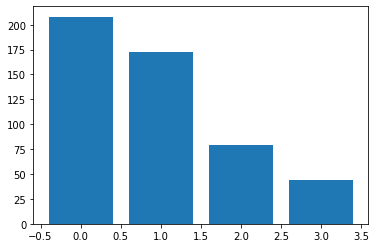

In [9]:
# Displaying the count of instances per predicted class.

from collections import Counter
counter = Counter(Y)
for k,v in counter.items():
    per = v / len(Y) * 100
    
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
# plot the distribution

plt.bar(counter.keys(), counter.values())
plt.show()

In [10]:
!pip install imblearn
!pip install imbalanced-learn

Class=0, n=208 (25.000%)
Class=2, n=208 (25.000%)
Class=1, n=208 (25.000%)
Class=3, n=208 (25.000%)


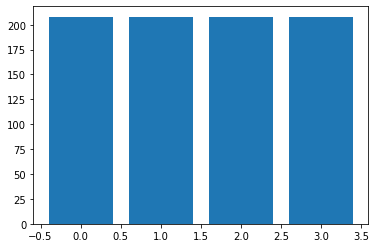

In [11]:
# SMOTE: Synthetic Minority Oversampling Technique.

from collections import Counter
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=7)
X, Y = oversample.fit_resample(X, Y)

# summarize distribution

counter = Counter(Y)
for k,v in counter.items():
    per = v / len(Y) * 100
    
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
# plot the distribution

plt.bar(counter.keys(), counter.values())
plt.show()

<font color='purple'><font size=8>Cross validation</font></font>

## is a technique used to find the optimal learning algorithm that can make accurate predictions and generalize well to unseen data. It involves determining the best way to divide the dataset into subsets for training and evaluation purposes.
The simplest approach, as illustrated in the figure below, involves three key sets in every machine learning algorithm:

Train set: Configured for learning and parameter estimation.

Validation set: Used for tuning hyperparameters, assessing predictive ability, and aiding in data preparation and feature selection. Validation is performed within the training set.

Test set: Provides an unbiased assessment of the final model's predictability for comparing and choosing between models.

In summary, model generation occurs through the training set, while performance evaluation is split between the validation and test sets. However, this division reduces the training data and can introduce randomness in set selection. An alternative to this is cross-validation (CV), which involves multiple rounds of sampling from the existing dataset, using different subsets each time.

Two common methods of cv are:

### 1. hold-out cv

This is one of the simplest data splitting methods, typically using an 80% training and 20% testing (or 90% and 10%) ratio. It's well-suited for large datasets, as it involves just one data split. This provides sample data for both training and testing the model's validity. However, it's important to note that this method may struggle with heterogeneous datasets, where sample independence in the selection of training and test sets is crucial. Another limitation is its inability to fine-tune hyperparameters, which can be addressed by employing a separate validation set. Yet, more flexible and reliable methods like nested cross-validation (nested CV) exist.

### 2. k-fold cv

K-fold cross-validation is a widely used method for model tuning and comparison. It involves dividing the original dataset into k subsets. Starting with the first subset (k=1) as the test set, the remaining k-1 subsets are used for training. The model's performance is evaluated on this test set, and the result is recorded. Repeating this process k times yields k independent models, each with its estimate (score) of model effectiveness. The final model score is obtained by calculating the average of these scores. This method allows for model comparison, helping us choose the one with the highest success rate.

The advantage of k-fold cross-validation is that it uses different subsets of the original data for both training and testing, providing better supervision for model evaluation. Choosing an appropriate value for k is essential. Larger k values generally lead to higher accuracy, but they come with increased time and computational costs. Additionally, for large k values, the original dataset must be sufficiently large to ensure the test set's size is suitable for model evaluation.

### 3. nested cv

Cross-validation (CV) is a method used for hyperparameter tuning and model comparison. One simple approach is to divide the data into three parts: a training set, a validation set, and a test set (figure below). The model is trained on the training set with various hyperparameter values, validated on the validation set, and its final performance is assessed on the test set. However, this method may not account for variability in the validation process and doesn't guarantee optimal hyperparameters.

Another common strategy is to use a hold-out method to create a test set and apply a different CV method to optimize hyperparameters on the training set. However, this approach provides only one test set, which can limit model evaluation.

A less favorable method, known as non-nested cross-validation, performs both validation and model evaluation on the same test set. This approach can introduce bias due to hyperparameter tuning.

#### To address these issues, nested k-fold cross-validation is used, involving two loops: an inner loop for hyperparameter tuning and an outer loop for comparing models with optimal hyperparameters. This method is computationally expensive, but it offers protection against overfitting and takes into account variability in both the test and validation sets.

In conclusion, CV determines the model with the highest predictive ability. It's essential when dealing with dependent data or small sample sizes. CV methods provide a comprehensive estimate of model performance, which depends on the number of iterations in k-fold or repeated k-fold. Finally, the optimal model is selected for predictions on new data after thorough evaluation with resampling methods.

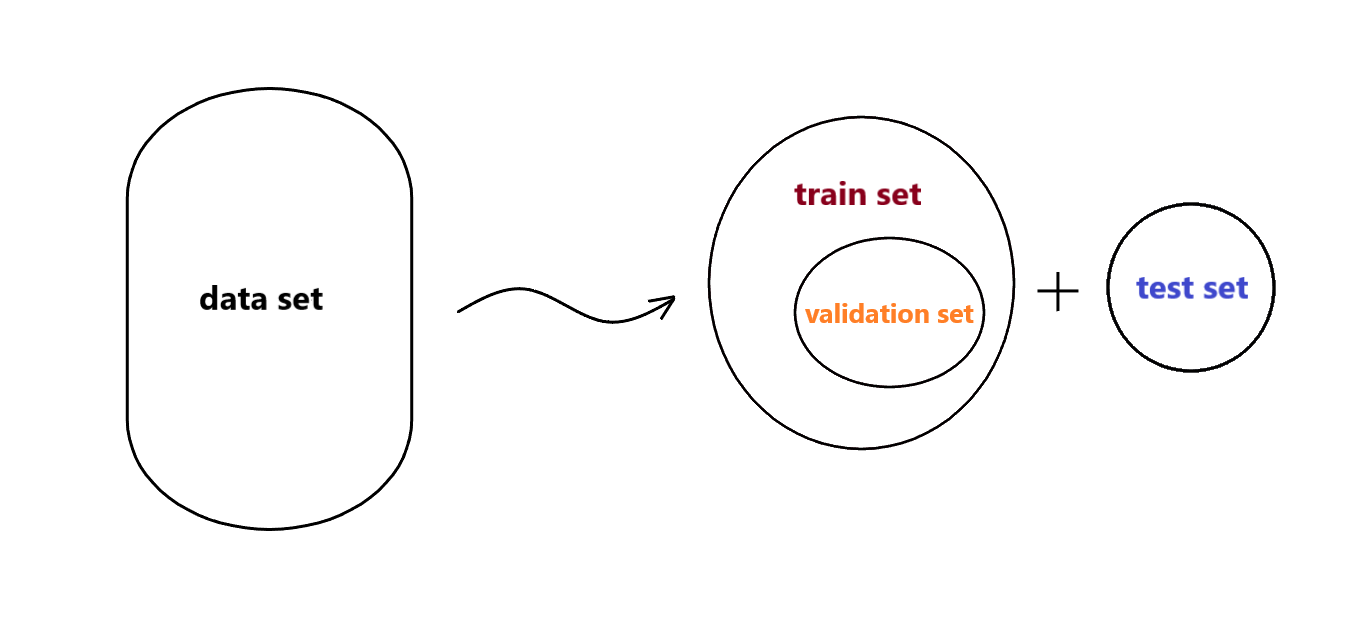

In [12]:
# Splitting dataset into training and test sets (hold-out cv).

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=3)

In [13]:
# Training a Gradient boosting classifier.
# By default GradientBoostingClassifier is built by 100 trees/stumps (n_estimators=100), 
# so it makes no sense in showing through a graph how an Adaboost classifier looks like! It's too complex!
# Also, the GradientBoostingClassifier function automatically handles multi-class problems.

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

gb_clf2 = GradientBoostingClassifier(random_state=0)
gb_clf2.fit(X_train, Y_train)

# Predict the response values for test dataset.

predictions = gb_clf2.predict(X_test)

# Overall metrics.
# Testing how well the model predicts according with the test set.
# Y_test is the exact response values of the test set, and we want to check if they match with those predicted by the model.

print("Classification Report")
print(classification_report(Y_test, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.81      0.85        69
           1       0.75      0.70      0.72        69
           2       0.93      0.85      0.89        66
           3       0.69      0.96      0.80        46

    accuracy                           0.82       250
   macro avg       0.82      0.83      0.82       250
weighted avg       0.83      0.82      0.82       250



<font color='red'><font size=8>Overfitting</font></font>

is a common issue that arises in the context of complex models when there is a scarcity of training examples relative to the numerous features. In such situations, the classifier's accuracy can exhibit significant discrepancies between the training data and various testing datasets used for validation. Overfitting is associated with a high degree of variance and indicates that the model is excessively focused on the training data, resulting in poor predictive performance on unseen testing data. To mitigate overfitting, one can either leverage a larger volume of data or simplify the model by reducing its dimensions, thus enhancing its ability to generalize. It's worth noting that models that are overly constrained as well as those that are overly flexible, are susceptible to overfitting and should be avoided.

## In summary, overfitting occurs when the classifier essentially memorizes the training set's outcomes rather than learning from them.

In [14]:
# Overfitting! So whereas accuracy = 0.82 (not that bad) we cannot trust the model due to overfitting...

gb_clf2.score(X_train,Y_train)

1.0

In [15]:
# Training a Gradient boosting classifier with Nested cv (it takes about 2 minutes to run...).
# Setting f1_micro, f1_macro, recall_micro, recall_macro etc, depending on what we need.
# Setting refit=True the model with the best parameters (best_estimator_) is automatically fitted to the entire data set.

from sklearn.model_selection import GridSearchCV,cross_val_score,RepeatedKFold,KFold

clf1=GradientBoostingClassifier(random_state=67)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
space=dict()
space['learning_rate']=[0.1, 0.5, 0.7, 1]
space['n_estimators']=[100, 200, 300, 400]
search = GridSearchCV(clf1, space, scoring='recall_micro', n_jobs=-1, cv=inner_cv, refit=True)
search.fit(X, Y)

nested_scores=cross_val_score(search, X, Y, scoring='recall_micro',cv=outer_cv, n_jobs=-1)
nested_scores

array([0.85628743, 0.79640719, 0.81325301, 0.80120482, 0.86746988])

In [16]:
search.best_params_

{'learning_rate': 0.7, 'n_estimators': 100}

In [17]:
nested_scores.mean()

0.8269244643243633

<font size=8>ΟVO and OVA (or OVR)</font>

Many algorithms, such as Logistic Regression, decision trees, and SVM, are inherently binary classifiers. In cases where we have more than two response classes (multi-class), and we seek predictions for a single class (rather than multiple, as in the multi-label problem), these algorithms require modification to operate effectively. To address this, combinatorial methods have been developed. These methods utilize binary classification procedures to design multiple classifiers using ensemble classification techniques.

### 1.OVR:

The One-Versus-Rest (OvR) or One-Versus-All (OVA) technique produces k binary classifiers when there are k classes in the target variable. For an observation x (input value) and classes C₁, ..., Cₖ, k binary models (hypotheses) are created with the following output values:

* hi(x) = +1, if x ∈ Ci

* hi(x) = -1, otherwise 

This approach involves training k classifiers, with each one deciding based on the rule of  "one class compared to the sum of the others".

For instance, consider a dataset with a total of 1000 examples of fruits divided into four different classes: 500 examples of 'apple,' 300 of 'pear,' 100 of 'tangerine,' and 100 of 'banana.' The goal is to predict the correct class among these four. To achieve this, k classifiers (here k=4) are created for the following binary classification problems:

Classifier No.1: {apple} vs {pear, tangerine, banana}

Classifier No.2: {pear} vs {apple, tangerine, banana}

Classifier No.3: {tangerine} vs {pear, apple, banana}

Classifier No.4: {banana} vs {pear, apple, tangerine}

The initial training set is modified k times to reflect the true values of the response variable. For the training of each classifier, a value of +1 is assigned to 'positive' classes with single elements, while a value of -1 is assigned to 'negative' heterogeneous classes with multiplicity greater than or equal to 2.

The training is conducted using standard binary classification techniques, and the final prediction is based solely on those models that predict the 'positive' class (an individual class rather than a combination). From these models, the result with the highest probability (confidence score) is selected.

If only one classifier predicts the 'positive' class, it is selected without comparing probabilities.

To test performance on new, unseen data, the same process is applied to each instance in the test dataset as was done during model construction. If the accuracy meets expectations, the model can be relied upon for making predictions.

### 2.OVO:

One-Versus-One (OVO), in a multi-class problem, decomposes into k(k-1)/2 binary class optimization problems, creating all possible combinations between the different classes. Each training set consists of one class to predict against one (and only one) other class, resulting in k times 2 combinations (C(k,2)) for each classifier.

In this approach, a 'negative' class is not a combined class for which we are uncertain about the algorithm's prediction; instead, it is a class with a clear negative sign and a distinct outcome. For example, in a problem with 4 classes, the combinations would be as follows:

Classifier No.1: {apple} vs {pear}

Classifier No.2: {apple} vs {tangerine}

Classifier No.3: {apple} vs {banana}

Classifier No.4: {pear} vs {banana}

Classifier No.5: {pear} vs {tangerine}

Classifier No.6: {tangerine} vs {banana}

The final prediction is determined by a majority decision. Initially, +1 values are assigned to the classes on the left column and -1 for those on the right. For instance, if we receive the following predictions from these classifiers:

No.1 → +1 (apple)

No.2 → +1 (apple)

No.3 → -1 (banana)

No.4 → -1 (banana)

No.5 → -1 (tangerine)

No.6 → -1 (banana)

In this scenario, since most predictions are 'negative,' we determine which 'negative' class prevails. In this case, the 'banana' class would be the final prediction.

In [18]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

In [19]:
# Training ОVO algorithm with the default hyperparameters of Gradient boosting algorithm.

OvO_clf = OneVsOneClassifier(GradientBoostingClassifier(random_state=0))
OvO_clf.fit(X_train, Y_train)

y_pred = OvO_clf.predict(X_test)

print('Precision-micro of OvO Classifier: {:.2f}'.format(precision_score(Y_test, y_pred, average='micro')))
print('Recall-micro of OvO Classifier: {:.2f}'.format(recall_score(Y_test, y_pred, average='micro')))
print('f1-micro of OvO Classifier: {:.2f}'.format(f1_score(Y_test, y_pred, average='micro')))

Precision-micro of OvO Classifier: 0.81
Recall-micro of OvO Classifier: 0.81
f1-micro of OvO Classifier: 0.81


In [20]:
# Training ОVO algorithm with nested cv.
# slow running about 5 min.
# Tuning hyperparameters with the OVO and OVR classifiers the 'estimator__' prefix is used for each hyperparameter we check.

clf=OneVsOneClassifier(GradientBoostingClassifier(random_state=6))
inner_cv = KFold(n_splits=5, shuffle= True, random_state=1)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)
space=dict()
space['estimator__n_estimators']=[100, 200, 300]
space['estimator__learning_rate']=[0.1, 0.5, 1]
search = GridSearchCV(clf, space, scoring='f1_micro', n_jobs=-1, cv=inner_cv, refit=True)
search.fit(X, Y)

nested_scores=cross_val_score(search, X, Y, scoring='f1_micro', cv=outer_cv, n_jobs=-1,error_score="raise")
nested_scores

array([0.88095238, 0.94047619, 0.8313253 , 0.79518072, 0.85542169,
       0.80722892, 0.89156627, 0.84337349, 0.89156627, 0.86746988])

In [21]:
nested_scores.mean()

0.8604561101549054

In [22]:
# Training ОVR algorithm with the default hyperparameters of Gradient boosting algorithm.

from sklearn.metrics import accuracy_score
OvR_clf = OneVsRestClassifier(GradientBoostingClassifier(random_state=0))
OvR_clf.fit(X_train, Y_train)

y_pred = OvR_clf.predict(X_test)

print('Precision-micro of OvR Classifier: {:.2f}'.format(precision_score(Y_test, y_pred, average='micro')))
print('Recall-micro of OvR Classifier: {:.2f}'.format(recall_score(Y_test, y_pred, average='micro')))
print('f1-micro of OvR Classifier: {:.2f}'.format(f1_score(Y_test, y_pred, average='micro')))

Precision-micro of OvR Classifier: 0.81
Recall-micro of OvR Classifier: 0.81
f1-micro of OvR Classifier: 0.81


In [23]:
# Training ОVR algorithm with nested cv.
# slow running about 10 min.
# Tuning hyperparameters with the OVO and OVR classifiers the 'estimator__' prefix is used for each hyperparameter we check.

clf=OneVsRestClassifier(GradientBoostingClassifier(random_state=6))
inner_cv = KFold(n_splits=5, shuffle= True, random_state=1)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)
space=dict()
space['estimator__n_estimators']=[100, 200, 300]
space['estimator__learning_rate']=[0.1, 0.5, 1]
search = GridSearchCV(clf, space, scoring='f1_micro', n_jobs=-1, cv=inner_cv, refit=True)
search.fit(X, Y)

nested_scores=cross_val_score(search, X, Y, scoring='f1_micro', cv=outer_cv, n_jobs=-1,error_score="raise")
nested_scores

array([0.9047619 , 0.91666667, 0.84337349, 0.8313253 , 0.79518072,
       0.8313253 , 0.86746988, 0.79518072, 0.86746988, 0.89156627])

In [24]:
nested_scores.mean()

0.8544320137693632

In [25]:
search.best_estimator_

OneVsRestClassifier(estimator=GradientBoostingClassifier(learning_rate=0.5,
                                                         n_estimators=300,
                                                         random_state=6))